Описание датасета: https://archive.ics.uci.edu/ml/datasets/Drug+consumption+%28quantified%29

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00373/drug_consumption.data

--2022-01-25 12:57:49--  https://archive.ics.uci.edu/ml/machine-learning-databases/00373/drug_consumption.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 346695 (339K) [application/x-httpd-php]
Saving to: ‘drug_consumption.data’

drug_consumption.da 100%[===================>] 338.57K  --.-KB/s    in 0.1s    

2022-01-25 12:57:49 (2.99 MB/s) - ‘drug_consumption.data’ saved [346695/346695]



In [ ]:
import numpy as np
import pandas as pd

data = pd.read_csv('drug_consumption.data', header=None, index_col=0)
# data.head()

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import recall_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import chi2, SelectKBest
!pip install catboost
from catboost import CatBoostClassifier

     |████████████████████████████████| 76.1 MB 1.2 MB/s 


## Анализ задачи
**Цель** - определить, зависим ли человек от различных легальных и нелегальных препаратов и продуктов, на основе разнообразных признаков, в том числе, психологических

**Где такая задача может быть применима?**

Знание о возможных зависимостях человека может пригодиться при найме сотрудников критически важные объекты, силовые структуры, на отвественные места в предприятиях (например, управленческие должности)

С этой точки зрения, ошибки FN опаснее, чем FP. Т.к. при ошибке FP возможны либо какие-то медицинские тесты, либо более тщательная психологическая проверка, либо просто отказ в устройстве на работу, а при ошибке FN - есть вероятность, что такой сотрудник может подвести, что опасно в силу критической важности его работы

Поэтому в качестве метрики для данной адачи логично взять **sensitivity** (recall)

Но зависимости от разных препаратов и продуктов из этого списка обладают разными рисками для здоровья, внимания, трудоспособности и т.д. Поэтому нужно задать веса, с которыми будут усредняться значения метрики для каждого целевого признака. (например, для кофе и шоколада - 1, для сигарет - 3, для тяжелых наркотиков, таких, как героин, метамфетамин и т.п. - 10)

## Чистка и разбиение данных
Отбросим ложные записи с теми респондентами, кто отвечал положительно на использование выдуманного наркотика "Semeron"  
Разделим датасет на признаковый и целевой

In [ ]:
if 30 in data.columns:
  data = data[data[30]=='CL0'].drop(30, axis=1)
target_cols = list(range(13,30))
target_cols.append(31)
target = data[target_cols]
X = data.drop(target_cols, axis=1)

Бинаризируем целевые данные, как указано в описании к датасету   
Разобьем данные на обучающую и тестовую выборки 

In [ ]:
replace_dict = dict()
for i in range(7):
  replace_dict[f'CL{i}'] = int(i>1) 
y = target.replace(to_replace=replace_dict)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## Категориальные признаки

Для отбора признаков воспользуемся критерием Хи-квадрат  
Преобразуем данные в неотрицательные так, чтобы сохранились категории

In [ ]:
X_non_neg_train = X_train - np.min(X_train, axis=0) 
all(X_non_neg_train.nunique() == X_train.nunique()) #совпадают ли количества уникальных значений во всех столбцах?

True

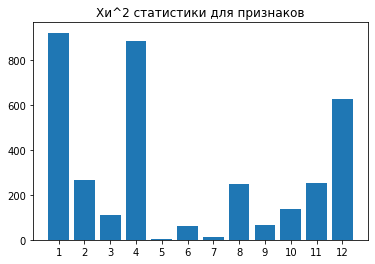

In [ ]:
fs = SelectKBest(score_func=chi2, k='all')
fs.fit(X_non_neg_train, y_train)
plt.bar(X.columns, fs.scores_, tick_label=X.columns)
plt.title('Хи^2 статистики для признаков');

Заметно, что 2 признака: 5 и 7, имеют низкий показатель, отбросим их

In [ ]:
fs = SelectKBest(score_func=chi2, k=10)
fs.fit(X_non_neg_train, y_train)
X_train = fs.transform(X_train)
X_test = fs.transform(X_test)
X_train.shape

(1501, 10)

Закодируем категориальные данные  
Количество уникальных значений каждого категориального признака

In [ ]:
X.nunique()

1      6
2      2
3      9
4      7
5      7
6     49
7     42
8     35
9     41
10    41
11    10
12    11
dtype: int64

Т.к. признаков не так много (12) и их уникальных значений тоже, то можно применить One-Hot Encoding

In [ ]:
dummies = pd.get_dummies(pd.DataFrame(np.vstack((X_train, X_test))), columns=range(X_train.shape[1]))
X_train = np.array(dummies.iloc[:X_train.shape[0],:])
X_test = np.array(dummies.iloc[X_train.shape[0]:,:])

Рассмотрим баланс классов в целевых признаках

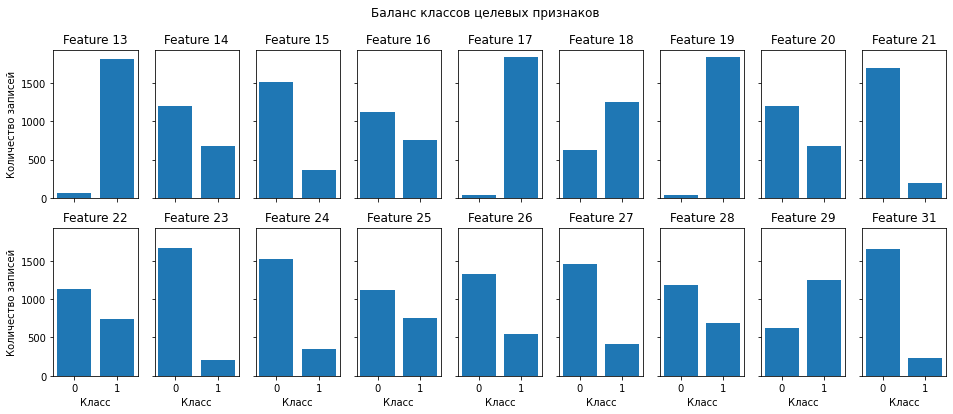

In [ ]:
fig, axs = plt.subplots(2,9, figsize=(16,6), sharex=True, sharey=True)
fig.suptitle('Баланс классов целевых признаков')

for i in range(2):
  for j in range(9):
    axs[i,j].bar(y.iloc[:,9*i+j].value_counts().index, height=y.iloc[:,9*i+j].value_counts().values)
    axs[i,j].set_title(f'Feature {y.columns[9*i+j]}')
    axs[i,j].set_xlabel('Класс')
    axs[i,j].set_ylabel('Количество записей');

for ax in axs.flat:
    ax.label_outer()

Классы несбалансированны, поэтому будем использовать сбалансированные веса при обучении моеделей

## Отбор моделей
Будем обучать модель на каждую целевую переменную, подбирая параметры для каждой отдельно по кросс-валидации с метрикой Recall

Выбор будем делать из нескольких алгоритмов
- SVM
- Случайный лес
- Логистическая регрессия
- Градиентный бустинг

Общее качество примененных алгоритмов будем сравнивать по взвешенной макроусредненной метрике Recall, чтобы правильно учитывались ошибки для каждого целевого признака

In [ ]:
label_weights = np.array([4,10,5,5,1,5,1,10,10,8,10,8,5,10,10,8,3,5]) 

def weighted_labels(y, weights=None):
  if weights is None:
      weights = np.ones(18) 
  norm_weights = weights / sum(weights)
  return np.sum(np.multiply(y, norm_weights))

In [ ]:
class MultiLabelModel:
  
  def __init__(self, estimator, cv=4, scoring='recall'):
    self.cv = 4
    self.est = estimator
    self.scoring = scoring

  def fit(self, X_, y_, grid):
    X = np.array(X_)
    y = np.array(y_)
    self.models = []
    self.score_ = []
    self.best_params_ = []
    for i in range(y.shape[1]):
      y_tar = y[:,i]
      cv = GridSearchCV(self.est, grid, cv=self.cv, scoring=self.scoring)
      cv.fit(X, y_tar)
      self.best_params_.append(cv.best_params_)
      self.score_.append(cv.best_score_)
      self.models.append(cv)

  def predict(self, X_):
    X = np.array(X_)
    y = np.zeros((X.shape[0], len(self.models)), dtype='int')
    for i in range(len(self.models)):
      y[:,i] = self.models[i].predict(X)
    return y

## SVC RBF

In [ ]:
mlm_svc_rbf_grid = {'C' : np.logspace(-3,1,20),
                    'kernel' : ['rbf'],
                    'class_weight' : ['balanced']}

mlm_svc_rbf = MultiLabelModel(SVC())
mlm_svc_rbf.fit(X_train, y_train, mlm_svc_rbf_grid)

In [ ]:
print(f'Best weighted macro averaged score = {weighted_labels(mlm_svc_rbf.score_, label_weights)}')

Best weighted macro averaged score = 0.8590507957546341


## SVC sigmoid

In [ ]:
mlm_svc_sig_grid = {'C' : np.logspace(-3,1,20),
                    'kernel' : ['sigmoid'],
                    'class_weight' : ['balanced']}

mlm_svc_sig = MultiLabelModel(SVC())
mlm_svc_sig.fit(X_train, y_train, mlm_svc_sig_grid)

In [ ]:
print(f'Best weighted macro averaged score = {weighted_labels(mlm_svc_sig.score_, label_weights)}')

Best weighted macro averaged score = 0.8292175956128898


## Logistic Regression 

In [ ]:
mlm_logreg_grid = {'solver' :['lbfgs', 'newton-cg'],
                  'C' : np.logspace(-3,1,20),
                  'class_weight' : ['balanced'],
                  'max_iter' : [1000]}

mlm_logreg = MultiLabelModel(LogisticRegression())
mlm_logreg.fit(X_train, y_train, mlm_logreg_grid)

In [ ]:
print(f'Best weighted macro averaged score = {weighted_labels(mlm_logreg.score_, label_weights)}')

Best weighted macro averaged score = 0.7381164425137825


## Random Forest

In [ ]:
mlm_rf_grid = {'n_estimators' : [50, 100, 200],
              'max_depth' : [2, 3, 4],
              'class_weight' : ['balanced'],
              'criterion' : ['gini', 'entropy']}

mlm_rf = MultiLabelModel(RandomForestClassifier())
mlm_rf.fit(X_train, y_train, mlm_rf_grid)

In [ ]:
print(f'Best weighted macro averaged score = {weighted_labels(mlm_rf.score_, label_weights)}')

Best weighted macro averaged score = 0.7269895172852657


## CatBoost

In [ ]:
mlm_catb_grid = {'learning_rate' : [0.05, 0.005],
                  'iterations' : [1000],
                  'depth': [4,6],
                  'l2_leaf_reg': [1,5], 
                  'verbose' : [0],
                  'eval_metric' : ['Recall'],
                  'early_stopping_rounds' : [300],
                  'auto_class_weights' : ['Balanced']}

mlm_catb = MultiLabelModel(CatBoostClassifier())
mlm_catb.fit(X_train, y_train, mlm_catb_grid)

In [ ]:
print(f'Best weighted macro averaged score = {weighted_labels(mlm_catb.score_, label_weights)}')

Best weighted macro averaged score = 0.7321718713117924


Лучший результат на кросс-валидации показал алгоритм SVC с ядром rbf и параметрами (для каждой целевой переменной):

In [ ]:
mlm_svc_rbf.best_params_

[{'C': 0.001, 'class_weight': 'balanced', 'kernel': 'rbf'},
 {'C': 0.001, 'class_weight': 'balanced', 'kernel': 'rbf'},
 {'C': 0.04832930238571752, 'class_weight': 'balanced', 'kernel': 'rbf'},
 {'C': 0.0026366508987303583, 'class_weight': 'balanced', 'kernel': 'rbf'},
 {'C': 0.001, 'class_weight': 'balanced', 'kernel': 'rbf'},
 {'C': 6.158482110660261, 'class_weight': 'balanced', 'kernel': 'rbf'},
 {'C': 0.011288378916846888, 'class_weight': 'balanced', 'kernel': 'rbf'},
 {'C': 0.5455594781168515, 'class_weight': 'balanced', 'kernel': 'rbf'},
 {'C': 0.001623776739188721, 'class_weight': 'balanced', 'kernel': 'rbf'},
 {'C': 0.018329807108324356, 'class_weight': 'balanced', 'kernel': 'rbf'},
 {'C': 0.001, 'class_weight': 'balanced', 'kernel': 'rbf'},
 {'C': 0.07847599703514611, 'class_weight': 'balanced', 'kernel': 'rbf'},
 {'C': 0.001, 'class_weight': 'balanced', 'kernel': 'rbf'},
 {'C': 0.20691380811147903, 'class_weight': 'balanced', 'kernel': 'rbf'},
 {'C': 0.20691380811147903, 'cla

Рассмотрим конечную точность полученной модели  

In [ ]:
y_pred = mlm_svc_rbf.predict(X_test)
weighted_labels(recall_score(y_test, y_pred, average=None), label_weights)

0.7414598772718838